In [1]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Average number of nodes 13396
Average maximum depth 46


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


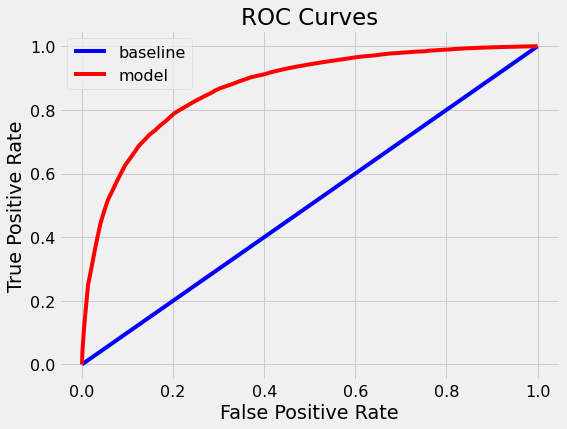

Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


<Figure size 432x288 with 0 Axes>

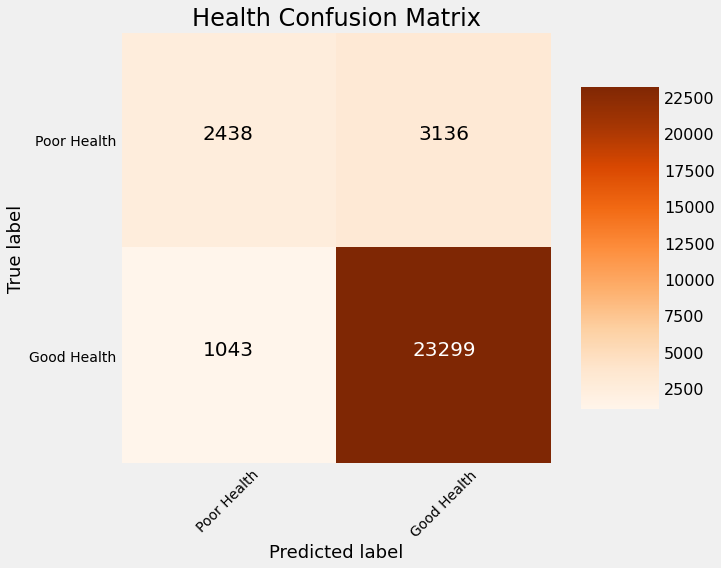

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

RSEED = 50

# Load in data
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Full dataset: https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, stratify = labels, test_size = 0.3, random_state = RSEED)

# Imputation of missing values
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

plt.savefig('cm.png')


In [ ]:
df.shape

(99719, 313)

In [ ]:
df.columns

Index(['_STATE', 'FMONTH', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1',
       'COLGHOUS', 'STATERES', 'CELLFON3',
       ...
       '_PAREC1', '_PASTAE1', '_LMTACT1', '_LMTWRK1', '_LMTSCL1', '_RFSEAT2',
       '_RFSEAT3', '_FLSHOT6', '_PNEUMO2', '_AIDTST3'],
      dtype='object', length=313)

In [ ]:
df.dtypes

_STATE      float64
FMONTH      float64
DISPCODE    float64
SEQNO       float64
_PSU        float64
             ...   
_RFSEAT2    float64
_RFSEAT3    float64
_FLSHOT6    float64
_PNEUMO2    float64
_AIDTST3    float64
Length: 313, dtype: object

In [ ]:
df.describe()

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
count,99719.000000,99719.000000,99719.000000,9.971900e+04,9.971900e+04,57421.0,57421.000000,8.0,57421.0,57421.000000,...,99719.000000,99719.000000,99063.000000,99063.000000,99063.000000,99719.000000,99719.000000,35593.000000,35593.000000,89897.000000
mean,29.927145,6.359621,1115.076365,2.015005e+09,2.015005e+09,1.0,1.000139,1.0,1.0,1.541892,...,3.490207,2.739338,2.715656,2.811706,3.649042,1.822180,1.885007,2.312927,2.422808,1.975984
std,16.041738,3.493738,35.782014,4.123848e+03,4.123848e+03,0.0,0.011803,0.0,0.0,0.498246,...,2.396112,2.446396,1.319996,1.349971,1.262371,2.357342,2.347899,2.540748,2.788391,1.452471
min,1.000000,1.000000,1100.000000,2.015000e+09,2.015000e+09,1.0,1.000000,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,19.000000,3.000000,1100.000000,2.015002e+09,2.015002e+09,1.0,1.000000,1.0,1.0,1.000000,...,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,29.000000,6.000000,1100.000000,2.015004e+09,2.015004e+09,1.0,1.000000,1.0,1.0,2.000000,...,3.000000,2.000000,3.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000
75%,44.000000,9.000000,1100.000000,2.015007e+09,2.015007e+09,1.0,1.000000,1.0,1.0,2.000000,...,4.000000,2.000000,3.000000,3.000000,4.000000,1.000000,1.000000,2.000000,2.000000,2.000000
max,72.000000,12.000000,1200.000000,2.015023e+09,2.015023e+09,1.0,2.000000,1.0,1.0,2.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99719 entries, 0 to 99718
Columns: 313 entries, _STATE to _AIDTST3
dtypes: float64(313)
memory usage: 238.1 MB


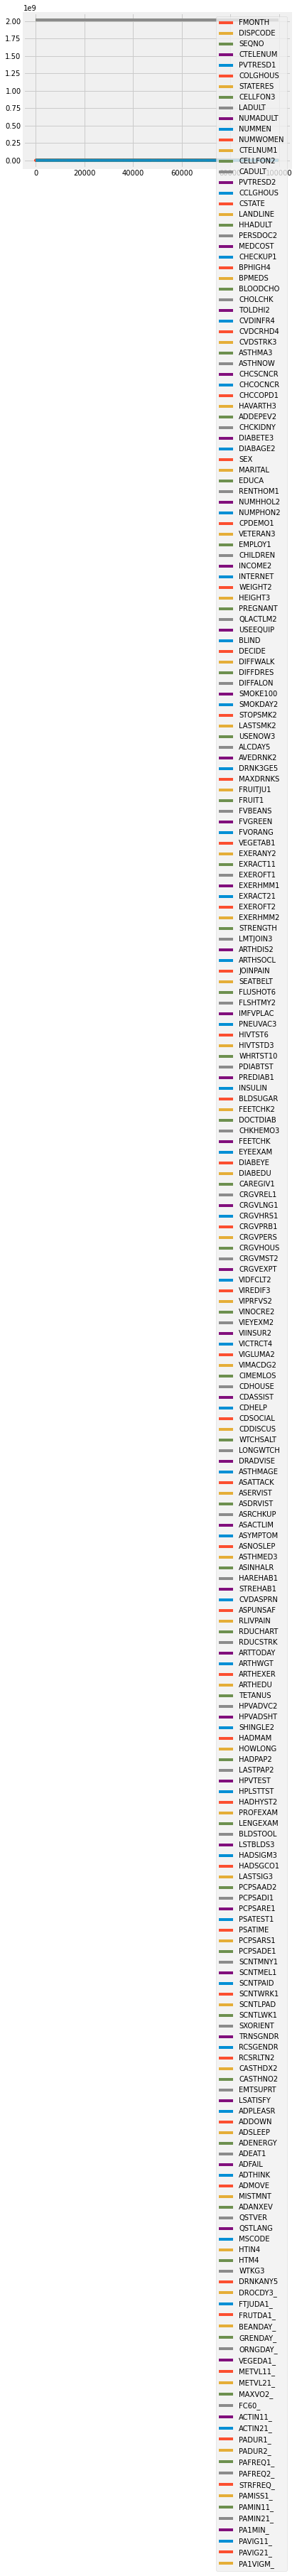

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
df.plot()

In [ ]:
corr_matrix = df.corr()
corr_matrix["FMONTH"].sort_values(ascending=False)

FMONTH      1.000000
SEQNO       0.245747
_PSU        0.245747
ASNOSLEP    0.143857
ASACTLIM    0.087032
              ...   
COLGHOUS         NaN
STATERES         NaN
CTELNUM1         NaN
CELLFON2         NaN
CCLGHOUS         NaN
Name: FMONTH, Length: 313, dtype: float64

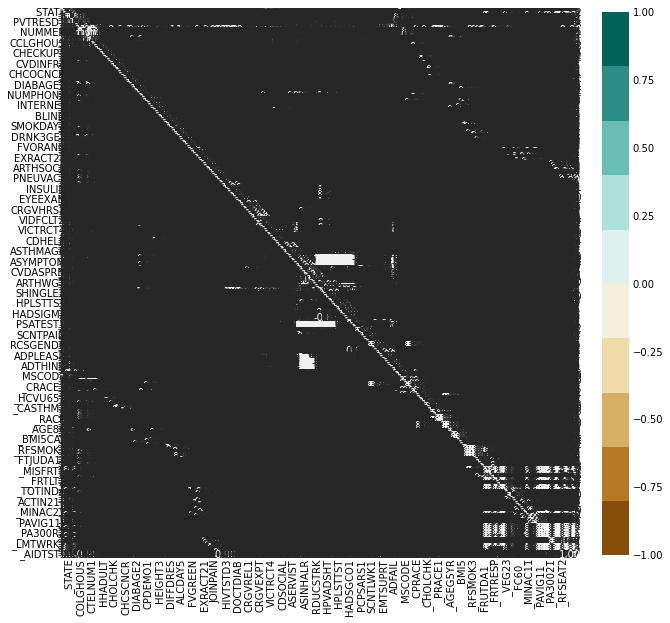

In [ ]:
import seaborn as sns
# Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
# Generate Color Map
# colormap = sns.diverging_palette(220, 10, as_cmap=True)
colormap = sns.color_palette("BrBG", 10)
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".2f")
#ax.set_yticklabels(column_names);
plt.show()

In [ ]:
#XGBOOST

In [ ]:
df.isnull().sum()

_STATE          0
FMONTH          0
DISPCODE        0
SEQNO           0
_PSU            0
            ...  
_RFSEAT2        0
_RFSEAT3        0
_FLSHOT6    64126
_PNEUMO2    64126
_AIDTST3     9822
Length: 313, dtype: int64

In [ ]:
X = df.drop('FMONTH', axis=1)

y = df['FMONTH']

In [ ]:
X.head()

,_STATE,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,LADULT,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,49.0,1100.0,2.015009e+09,2.015009e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
1,9.0,1100.0,2.015005e+09,2.015005e+09,1.0,1.0,NaN,1.0,1.0,NaN,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
2,34.0,1100.0,2.015011e+09,2.015011e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
3,41.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,1.0,NaN,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
4,54.0,1100.0,2.015004e+09,2.015004e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


In [ ]:
y.head()

0     4.0
1     9.0
2    10.0
3     4.0
4     5.0
Name: FMONTH, dtype: float64

In [ ]:
y[y == 2] = 0

y[y == 1] = 1

In [ ]:
import xgboost as xgb


# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
from xgboost import XGBClassifier


# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
            
            
            
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)



# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, learning_rate=1.0, max_depth=4,
              objective='multi:softprob')

In [ ]:
print(xgb_clf)

XGBClassifier(alpha=10, learning_rate=1.0, max_depth=4,
              objective='multi:softprob')


In [ ]:
y_pred = xgb_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.4235


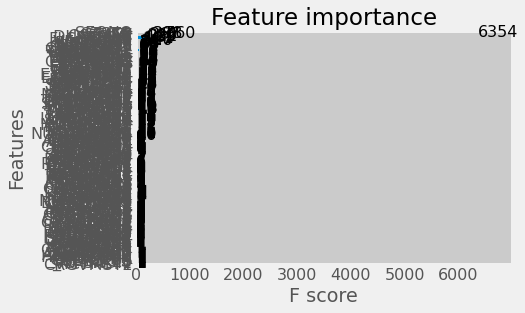

In [ ]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

In [ ]:
#not used

LinAlgError: ignored

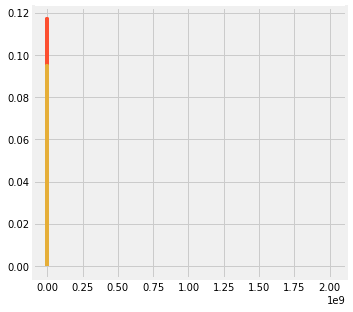

In [ ]:
df.plot(kind='density',subplots=False,layout=(20,16),figsize=(5,5),sharex=False)
plt.show()

In [ ]:
df['fmonth'].value_counts()

KeyError: ignored